In [94]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.constants import c as clight
from astropy.constants import e as e_elec
from astropy.constants import h as hplanck
from astropy.cosmology import WMAP9 as cosmo
import fitting
import scipy.optimize as opt               # this is needed for chi-squared minimization


clight_kmps=clight.to("km/s").value

plt.rcParams["text.usetex"]=True
plt.rcParams["axes.labelsize"]=20
plt.rcParams["xtick.labelsize"]=20
plt.rcParams["ytick.labelsize"]=20
plt.rcParams["legend.fontsize"]=20

In [89]:
LyC_AA=12398.42/13.6

In [102]:
H0=cosmo.H(0).value

In [109]:
kapbg=1./(mfp*3.08e24)

In [145]:
def fit_func_dist_equal_wv(wv_rest_arr,lamb, zqso, Req, xi,xsec_index=2.75):
    """
    make sure dAA is small enough
    """
    kapbg=1/lamb # in unit 1/pMpc
    drArr=-(wv_rest_arr[1:]-wv_rest_arr[:-1])/LyC_AA*clight_kmps/Hz
    rArr=np.cumsum(drArr)

    z912=wv_rest_arr/LyC_AA*(1+zqso)-1

    dzpArr=z912[1:]-z912[:-1]

    Gq_o_Gbg=np.zeros_like(rArr)
    kapr=np.zeros_like(rArr)
    kapr[0]=0
    Gq_o_Gbg[0]=(rArr[0]/Req)**(-2) #Eq7
    for i in range(1,len(rArr)):
        kapr[i]=kapbg*(1+Gq_o_Gbg[i-1])**(-xi) #Eq4
        Gq_o_Gbg[i]=Gq_o_Gbg[i-1]*(rArr[i]/rArr[i-1])**(-2)*np.exp(-kapr[i-1]*drArr[i-1]) #Eq8

    kap_zp=kapr
    zpArr=z912[1:]

    integrand=kap_zp*(1+zpArr)**(-xsec_index-2.5)*dzpArr

    integ=-np.cumsum(integrand)

    tau_eff=clight_kmps/H0/cosmo.Om0**0.5*(1+z912[1:])**xsec_index*integ
    
    return np.exp(-tau_eff)

In [116]:
def fit_func_convolved(wv_rest,lamb,zqso,Req,xi,debug=True):
    kapbg=1./lamb/3.08e24
    tau_eff=[]
    for wv in wv_rest:
        tau_eff.append(-fitting.tau_LyC(wv,zqso,Req,xi,kapbg))
    return np.exp(-np.array(tau_eff))

In [119]:
auni=0.1552
xlimb=820
zqso=1./auni-1
print("z=",zqso)
Hz=cosmo.H(zqso).value

qso_t1e7_tau_profiles=np.load(data_path+"new_tau_profiles_F_a{:6.4f}_qso_Ndot1.4e57_tQ1e7yr.npy".format(auni))
mean_p_t1e7=np.mean(np.exp(-qso_t1e7_tau_profiles),axis=0)


z= 5.443298969072165


In [146]:
Req=10 #pMpc
xi=0.67
mfp=5.9
custom_func=lambda wv_rest, lamb:fit_func_dist_equal_wv(wv_rest, lamb, zqso, Req, xi)

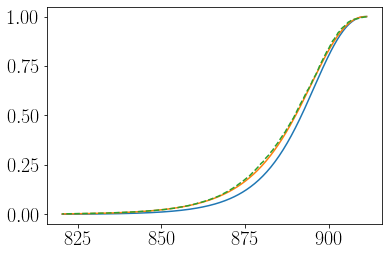

In [147]:
plt.plot(wv_rest_arr[1:],custom_func(wv_rest_arr,6))
plt.plot(wv_rest_arr[1:],custom_func(wv_rest_arr,7))
plt.plot(wv_rest_arr[1:], mean_p_t1e7[1:],ls="--")

In [148]:
data_path="/data/hqchen/mfp_project/data/"
wv_rest_arr=np.loadtxt(data_path+"new_AAout.txt")

In [151]:
params, params_covariance = opt.curve_fit(custom_func, wv_rest_arr, mean_p_t1e7[1:], p0 = mfp)

In [152]:
params

array([7.19516741])